In [1]:
import pandas as pd 
import numpy as np

import re

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
stemmer = PorterStemmer()
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
!pip install sagemaker==1.72.0

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


## Load data

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [4]:
def clean_text(string):
    """
    Tokenization/string cleaning for datasets.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"\'s", "", string)
    string = re.sub(r"\'ve", "", string)
    string = re.sub(r"n\'t", "", string)
    string = re.sub(r"\'re", "", string)
    string = re.sub(r"\'d", "", string)
    string = re.sub(r"\'ll", "", string)
    string = re.sub(r",", "", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", "", string)
    string = re.sub(r"\)", "", string)
    string = re.sub(r"\?", "", string)
    string = re.sub(r"'", "", string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"[0-9]\w+|[0-9]","", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

def review_to_words(review):
    text = BeautifulSoup(review, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    text = clean_text(text)
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = ' '.join([PorterStemmer().stem(w) for w in words]) # stem
    
    return words

In [5]:
train_data["clean_text"] = train_data["text"].apply(lambda row:review_to_words(row))
test_data["clean_text"] = test_data["text"].apply(lambda row:review_to_words(row))

## Analyze cleaned text

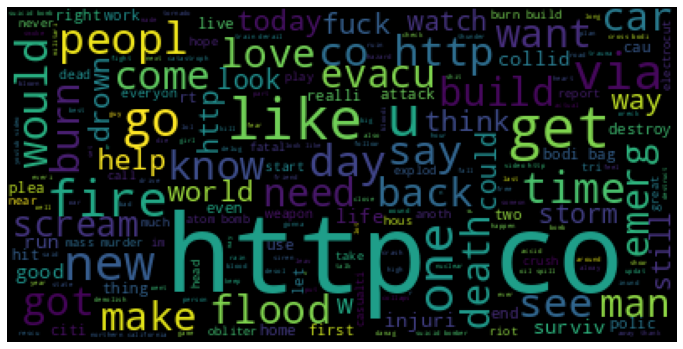

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

stop_words = stopwords.words("english")
xc = ''.join(train_data['clean_text'])
wc = WordCloud(stopwords=stop_words,
              background_color='black',
              max_words=200).generate(xc)


plt.figure(figsize=(12,16))
plt.imshow(wc)
plt.axis('off')
plt.show()

## use TfidfTransformer to generate feature for test and train set

In [5]:
pipe = Pipeline([('count', CountVectorizer()),
                 ('tfid', TfidfTransformer())])
train_feature = pipe.fit_transform(train_data["clean_text"]).toarray()
test_feature = pipe.transform(test_data["clean_text"] ).toarray()

print(train_feature.shape)
print(test_feature.shape)

(7613, 15774)
(3263, 15774)


## Save data to csv file and upload

In [6]:
import sagemaker
from sagemaker import get_execution_role

session = sagemaker.Session() # Store the current SageMaker session
role = get_execution_role()


In [7]:
import os

data_dir = '../data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

## save data to csv file
pd.concat([train_data["target"],pd.DataFrame(train_feature)], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)
pd.DataFrame(test_feature).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

# upload to s3
prefix = 'predict-disaster'
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)
test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)

## Train the model with Pytorch

In [8]:
# import a PyTorch wrapper
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role

bucket = session.default_bucket()
# specify an output path
# prefix is specified above
output_path = 's3://{}/{}'.format(bucket, prefix)
input_dim = train_feature.shape[1]
# instantiate a pytorch estimator
estimator = PyTorch(entry_point='train.py',
                    source_dir='script', # this should be just "source" for your code
                    role=role,
                    framework_version='1.0',
                    train_instance_count=1,
                    train_instance_type='ml.c4.xlarge',
                    output_path=output_path,
                    sagemaker_session=session,
                    hyperparameters={
                        'input_dim': input_dim,  # num of features
                        'hidden_dim': 40,
                        'output_dim': 1,
                        'epochs': 40 # could change to higher
                    })

In [9]:
# train the estimator on S3 training data
estimator.fit({'train': train_location})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2021-08-01 11:54:05 Starting - Starting the training job...
2021-08-01 11:54:07 Starting - Launching requested ML instances......
2021-08-01 11:55:17 Starting - Preparing the instances for training.........
2021-08-01 11:56:57 Downloading - Downloading input data
2021-08-01 11:56:57 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-08-01 11:57:18,912 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-08-01 11:57:18,914 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-08-01 11:57:18,926 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-08-01 11:57:18,928 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-08-01 11:57:19,201 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2021-08-01 11:57:19,

## Deploy model and predict data on test set

In [10]:
from sagemaker.pytorch import PyTorchModel

# Create a model from the trained estimator data
# And point to the prediction script
model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='1.0',
                     entry_point='predict.py',
                     source_dir='script')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [11]:
%%time
# deploy and create a predictor
predictor = model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-----------------!CPU times: user 429 ms, sys: 10.9 ms, total: 440 ms
Wall time: 8min 32s


In [12]:
prediction = [] #np.squeeze(np.round(predictor.predict(test_feature)))
for i in range(len(test_feature)):
    prediction.append((int(np.round(predictor.predict(test_feature[i]))[0])))

In [13]:
## output values as csv file
predict = pd.DataFrame(prediction)
predict["id"] = test_data["id"].values
predict["target"] = prediction
predict[["id","target"]].to_csv("predict.csv", index=False)

## Evaluation

The result is submitted to Kaggle, the score is 0.76677

## Clean resources

In [16]:
predictor.delete_endpoint()